## How to use **`RNA_counts`** and **`DR`** classes
C. Heiser, June 2019

In [1]:
import sys
sys.path.append("../")
from fcc_DRs import * # contains dimensionality reduction classes
from fcc_utils import * # contains code necessary for distance preservation analysis

DCA module not detected. Functionality will be disabled.


`RNA_counts` objects can be read straight from a file, or generated from an existing pandas dataframe or numpy array.  
These files can be comma- or tab-delimited, and compressed with `.zip` or `.gz`.  
Here, we will read in a file from [Macosko, _et al._ (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26000488), which has cell and gene labels, and is in a cells-by-genes format.

In [2]:
continuous = RNA_counts.from_file(datafile='../inputs/sim_path.csv', labels=[0,0], cells_axis=1)

In [11]:
sim_path_obs = pd.read_csv('../inputs/sim_path_obs.csv', index_col=0)

In [20]:
discrete = RNA_counts.from_file(datafile='../inputs/sim_discrete.csv', labels=[0,0], cells_axis=1)

In [21]:
sim_discrete_obs = pd.read_csv('../inputs/sim_discrete_obs.csv', index_col=0)

save `.tsv` versions of counts matrices without cell IDs for `scvis`

In [42]:
continuous.data.astype('float').to_csv("../inputs/sim_path.norowlabels.tsv", index=False, sep="\t")

In [43]:
discrete.data.astype('float').to_csv("../inputs/sim_discrete.norowlabels.tsv", index=False, sep="\t")

save `.tsv` versions of counts matrices without cell IDs for `dca`

In [44]:
continuous.data.astype('float').to_csv("../inputs/sim_path.genexcell.tsv", index=True, sep="\t")

In [45]:
discrete.data.astype('float').to_csv("../inputs/sim_discrete.genexcell.tsv", index=True, sep="\t")

These objects have a bunch of useful attributes:

In [6]:
continuous.data # gives the full data as pd.DataFrame, including cell and gene IDs if available
continuous.counts # gives the counts matrix as a np.array
continuous.cell_IDs # list of cell IDs from labels
continuous.gene_IDs # list of gene IDs from labels

Index(['Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5', 'Gene6', 'Gene7', 'Gene8',
       'Gene9', 'Gene10',
       ...
       'Gene491', 'Gene492', 'Gene493', 'Gene494', 'Gene495', 'Gene496',
       'Gene497', 'Gene498', 'Gene499', 'Gene500'],
      dtype='object', length=500)

We can look at the total number of cells and genes by the shape of the `data` attribute.

In [7]:
continuous.data.shape

(3060, 500)

In [13]:
# generate PCA object for arcsinh-transformed data with 100 components
%time continuous_ZIFA = fcc_ZIFA(continuous.arcsinh_norm(norm='l1', scale=1000), K=2)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 3060, D = 481, K = 2, n_blocks = 1
Block sizes [481]
Param change below threshold 1.000e-02 after 7 iterations
CPU times: user 7min 15s, sys: 46.2 s, total: 8min 2s
Wall time: 1min 26s


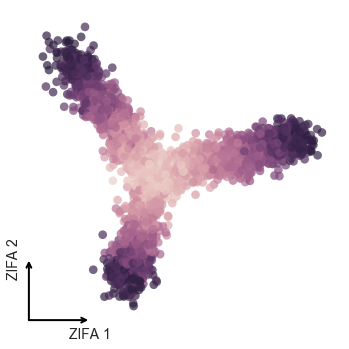

In [14]:
# look at the results
continuous_ZIFA.plot(color=sim_path_obs.Step)

In [19]:
np.savetxt(X=continuous_ZIFA.results, fname="outputs/embeddings/sim_path_ZIFA.csv", delimiter=",")

In [22]:
# generate PCA object for arcsinh-transformed data with 100 components
%time discrete_ZIFA = fcc_ZIFA(discrete.arcsinh_norm(norm='l1', scale=1000), K=2)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1873, D = 479, K = 2, n_blocks = 1
Block sizes [479]
Param change below threshold 1.000e-02 after 7 iterations
CPU times: user 4min 48s, sys: 37.1 s, total: 5min 26s
Wall time: 58 s


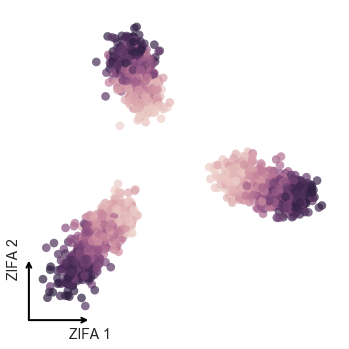

In [23]:
# look at the results
discrete_ZIFA.plot(color=sim_discrete_obs.Step)

In [24]:
np.savetxt(X=discrete_ZIFA.results, fname="outputs/embeddings/sim_discrete_ZIFA.csv", delimiter=",")

In [26]:
%time continuous_FItSNE = fcc_FItSNE(continuous.arcsinh_norm(norm='l1', scale=1000), perplexity=30)

CPU times: user 487 ms, sys: 40.2 ms, total: 527 ms
Wall time: 11.1 s


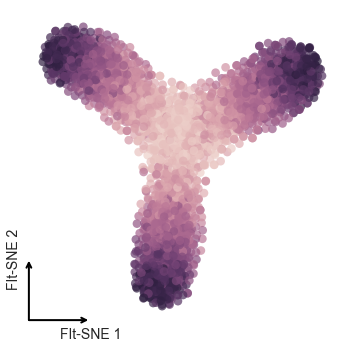

In [27]:
# look at the results
continuous_FItSNE.plot(color=sim_path_obs.Step)

In [28]:
np.savetxt(X=continuous_FItSNE.results, fname="outputs/embeddings/sim_path_FItSNE.csv", delimiter=",")

In [29]:
%time discrete_FItSNE = fcc_FItSNE(discrete.arcsinh_norm(norm='l1', scale=1000), perplexity=30)

CPU times: user 203 ms, sys: 21.8 ms, total: 225 ms
Wall time: 8.11 s


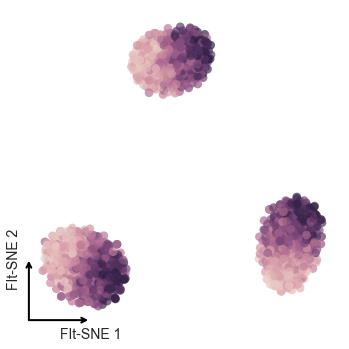

In [30]:
# look at the results
discrete_FItSNE.plot(color=sim_discrete_obs.Step)


In [31]:
np.savetxt(X=discrete_FItSNE.results, fname="outputs/embeddings/sim_discrete_FItSNE.csv", delimiter=",")

---
## scVI

In [47]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

[2020-03-04 09:46:08,375] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/Users/cody/.virtualenvs/fcc/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [51]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('sim_path.csv', save_path='../inputs/', new_n_genes=500, gene_by_cell=True, sep=',')

[2020-03-04 09:48:31,152] INFO - scvi.dataset.csv | Preprocessing dataset
[2020-03-04 09:48:31,423] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2020-03-04 09:48:31,430] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-04 09:48:31,431] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-04 09:48:31,436] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:48:31,439] INFO - scvi.dataset.dataset | Downsampled from 3060 to 3060 cells
[2020-03-04 09:48:31,440] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=500) <= self.nb_genes


In [52]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|██████████| 400/400 [02:35<00:00,  2.58it/s]


In [53]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

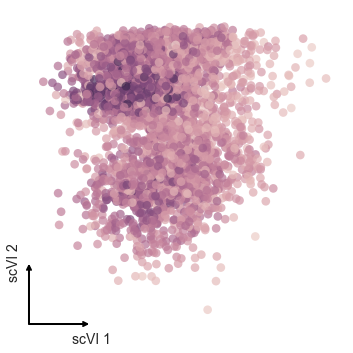

In [57]:
retina_scVI = DR(latent=latent.astype('double'), name='scVI')
retina_scVI.plot()

In [59]:
retina_scVI.results.shape

(3060, 10)

In [60]:
np.savetxt(X=retina_scVI.results, fname='outputs/embeddings/sim_path_scVI.csv', delimiter=',')


Perform t-SNE on scVI output to visualize

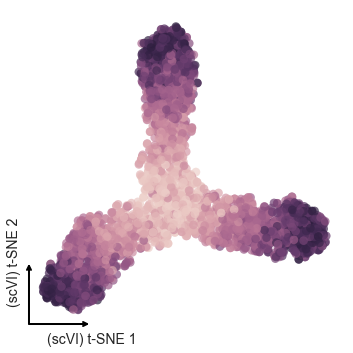

CPU times: user 444 ms, sys: 44.5 ms, total: 488 ms
Wall time: 180 ms


In [63]:
%%time
retina_scVI_tSNE = fcc_tSNE(retina_scVI.results, perplexity=30, seed=18)
retina_scVI_tSNE.name = '(scVI) t-SNE'
retina_scVI_tSNE.plot(color=sim_path_obs.Step)


In [64]:
# Loading a local dataset into scVI
discrete_scVI = CsvDataset('sim_discrete.csv', save_path='../inputs/', new_n_genes=500, gene_by_cell=True, sep=',')

[2020-03-04 10:09:04,192] INFO - scvi.dataset.csv | Preprocessing dataset
INFO:scvi.dataset.csv:Preprocessing dataset
[2020-03-04 10:09:04,349] INFO - scvi.dataset.csv | Finished preprocessing dataset
INFO:scvi.dataset.csv:Finished preprocessing dataset
[2020-03-04 10:09:04,356] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]
[2020-03-04 10:09:04,357] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
[2020-03-04 10:09:04,361] INFO - scvi.dataset.dataset | Computing the library size for the new data
INFO:scvi.dataset.dataset:Computing the library size for the new data
[2020-03-04 10:09:04,364] INFO - scvi.dataset.dataset | Downsampled from 1873 to 1873 cells
INFO:scvi.dataset.dataset:Downsampled from 1873 to 1873 cells
[2020-03-04 10:09:04,365] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=500) <= self.nb_genes
INFO:scvi.dataset

In [65]:
vae = VAE(discrete_scVI.nb_genes, n_batch=discrete_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              discrete_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|██████████| 400/400 [01:36<00:00,  4.16it/s]


In [66]:
full = trainer.create_posterior(trainer.model, discrete_scVI, indices=np.arange(len(discrete_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

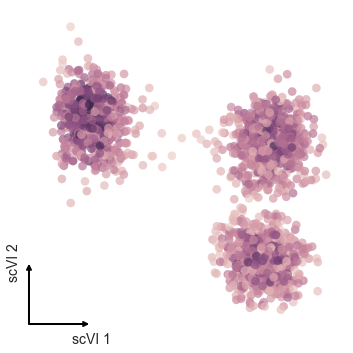

In [67]:
discrete_scVI = DR(latent=latent.astype('double'), name='scVI')
discrete_scVI.plot()

In [68]:
discrete_scVI.results.shape

(1873, 10)

In [69]:
np.savetxt(X=discrete_scVI.results, fname='outputs/embeddings/sim_discrete_scVI.csv', delimiter=',')

Perform t-SNE on scVI output to visualize

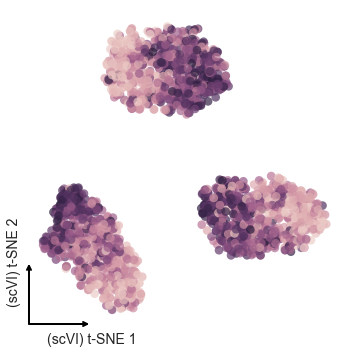

CPU times: user 16.9 s, sys: 72.9 ms, total: 16.9 s
Wall time: 16.7 s


In [70]:
%%time
discrete_scVI_tSNE = fcc_tSNE(discrete_scVI.results, perplexity=30, seed=18)
discrete_scVI_tSNE.name = '(scVI) t-SNE'
discrete_scVI_tSNE.plot(color=sim_discrete_obs.Step)